# 📒 TELCO CHURN — MASTER NOTEBOOK (Senior DS Edition)

## 0) Kurulum, Amaç, Çıktılar

Bu notebook'un hedefi: **Telco Customer Churn** verisi üzerinde uçtan uca Data Scientist sürecini, yalnızca "çalışan kod" değil **üretim kalitesine yakın (production-grade)** bir yapı ile sunmaktır.

Bu notebook şu **deliverable**'ları üretir:

| # | Çıktı | Açıklama |
|---|-------|----------|
| 1 | **Data Health & Audit tablosu** | Doluluk, benzersiz değer, entropy, skewness vb. |
| 2 | **Business logic ile temizlik** | Özellikle `TotalCharges` dönüşümü |
| 3 | **İleri seviye Feature Engineering** | En az 5–6 yeni özellik |
| 4 | **İstatistiksel anlamlılık testleri** | Kategorikler → Chi-Square · Sayısallar → Welch T-Test |
| 5 | **Multicollinearity analizi (VIF)** | Variance Inflation Factor |
| 6 | **Profesyonel EDA** | Heatmap, Violin, interaktif Plotly grafikler |
| 7 | **PCA boyut indirgeme + Scree plot** | Kümülatif varyans analizi |
| 8 | **Final export** | Model eğitimine hazır matrisleri `artifacts/` içine kaydetme |

In [1]:
# =========================
# 1) Imports & Config
# =========================

import os
import json
import math
import warnings
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Interaktif grafikler
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "vscode"

# İstatistik
from scipy import stats
from scipy.stats import chi2_contingency

# ML preprocessing / PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# VIF için
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")

# Notebook görsel ayarları
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

RANDOM_STATE = 42

ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [2]:
# =========================
# 2) Utility: Schema / IO
# =========================

@dataclass(frozen=True)
class TelcoConfig:
    """
    Bu config, veri seti kolon adları farklı olsa bile uyarlanabilirlik sağlar.
    Eğer senin verinde target farklı isimdeyse burada güncelleyebilirsin.
    """
    id_col: str = "customerID"
    target_col: str = "Churn"
    
    # Sık görülen sayısal alanlar (varsa)
    numeric_hints: Tuple[str, ...] = ("tenure", "MonthlyCharges", "TotalCharges")
    
    # Raw -> binary churn mapping (Yes/No veya 1/0)
    churn_positive_values: Tuple = ("Yes", 1, "1", True)

class DataIO:
    @staticmethod
    def load(path: str) -> pd.DataFrame:
        """
        NEDEN:
          - IO tek yerde olmalı: tekrar üretilebilirlik + bakım kolaylığı.
        """
        if path.endswith(".csv"):
            return pd.read_csv(path)
        if path.endswith(".parquet"):
            return pd.read_parquet(path)
        if path.endswith(".xlsx") or path.endswith(".xls"):
            return pd.read_excel(path)
        raise ValueError(f"Desteklenmeyen format: {path}")

    @staticmethod
    def save_json(obj: dict, path: str) -> None:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(obj, f, ensure_ascii=False, indent=2)

    @staticmethod
    def save_parquet(df: pd.DataFrame, path: str) -> None:
        df.to_parquet(path, index=False)

def infer_column_types(df: pd.DataFrame, cfg: TelcoConfig) -> Tuple[List[str], List[str]]:
    """
    NEDEN:
      - Sayısal ve kategorik kolonları otomatik ayırmak pipeline kurulumunu kolaylaştırır.
      - Ancak bazı kolonlar 'object' gelir ama sayısaldır (TotalCharges gibi).
    """
    numeric_cols = []
    categorical_cols = []
    
    for c in df.columns:
        if c == cfg.target_col:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            numeric_cols.append(c)
        else:
            categorical_cols.append(c)
    
    # numeric_hints ile "object ama aslında numeric" olabilecekleri yakalamaya yardımcı olur
    # (temizlikten sonra tekrar çağırmak daha doğru)
    return numeric_cols, categorical_cols


In [3]:
# =========================
# 3) Load Dataset
# =========================

cfg = TelcoConfig()

DATA_PATH = "../data/raw/churn.csv"  

df_raw = DataIO.load(DATA_PATH)
print(df_raw.shape)
df_raw.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Target standardizasyonu
df = df_raw.copy()

if cfg.target_col in df.columns:
    # Churn değerlerini 0/1'e çevir (Yes/No veya 1/0)
    if df[cfg.target_col].dtype == "object":
        df[cfg.target_col] = df[cfg.target_col].apply(lambda x: 1 if x in cfg.churn_positive_values else 0).astype(int)
    else:
        # numeric already; yine de güvenlik
        df[cfg.target_col] = df[cfg.target_col].astype(int)

df[cfg.target_col].value_counts(dropna=False)


Churn
0    5174
1    1869
Name: count, dtype: int64

## 4) Data Health & Audit — "Veri Sağlık Denetimi"

Bu bölümde amaç, **"verinin genel sağlığını"** tek bir tablo ile raporlamaktır.
Sadece `dtype` veya null saymak yetmez; ayrıca:

- **Doluluk oranı** (`fill_rate`)
- **Unique değer sayısı ve oranı**
- **Entropy** — özellikle kategoriklerde dağılımın "ne kadar uniform" olduğunu gösterir
- **Skewness** — sayısal dağılım çarpıklığı
- **Sık görülen değerler** (top-3)

In [5]:
# =========================
# 4) Data Health & Audit
# =========================

def shannon_entropy(series: pd.Series) -> float:
    """
    Shannon entropy:
      - Kategorik değişkenin dağılımı ne kadar dengeli?
      - Entropy yüksekse: sınıflar daha uniform
      - Entropy düşükse: 1-2 değer baskın
    """
    s = series.dropna()
    if len(s) == 0:
        return 0.0
    probs = s.value_counts(normalize=True)
    return float(-(probs * np.log2(probs)).sum())

def top_values(series: pd.Series, k: int = 3) -> str:
    s = series.dropna()
    if len(s) == 0:
        return ""
    vc = s.value_counts().head(k)
    # "value(count)" formatı
    return ", ".join([f"{idx}({cnt})" for idx, cnt in vc.items()])

def data_health_audit(df: pd.DataFrame, target_col: Optional[str] = None) -> pd.DataFrame:
    rows = []
    n = len(df)
    
    for col in df.columns:
        if target_col and col == target_col:
            continue
        
        s = df[col]
        dtype = str(s.dtype)
        nulls = int(s.isna().sum())
        fill_rate = float(1 - nulls / n)
        nunique = int(s.nunique(dropna=True))
        unique_rate = float(nunique / n) if n > 0 else 0.0
        
        ent = shannon_entropy(s) if dtype == "object" or dtype == "bool" else shannon_entropy(s.astype(str))
        
        # skewness sadece numeric için anlamlı (object için NaN bırak)
        skew = float(pd.to_numeric(s, errors="coerce").skew()) if pd.api.types.is_numeric_dtype(s) else float(pd.to_numeric(s, errors="coerce").skew())
        
        # basic stats numeric için
        s_num = pd.to_numeric(s, errors="coerce")
        mean = float(s_num.mean()) if s_num.notna().sum() > 0 else np.nan
        std = float(s_num.std()) if s_num.notna().sum() > 0 else np.nan
        p01 = float(s_num.quantile(0.01)) if s_num.notna().sum() > 0 else np.nan
        p99 = float(s_num.quantile(0.99)) if s_num.notna().sum() > 0 else np.nan
        
        rows.append({
            "column": col,
            "dtype": dtype,
            "null_count": nulls,
            "fill_rate": round(fill_rate, 4),
            "n_unique": nunique,
            "unique_rate": round(unique_rate, 4),
            "entropy": round(ent, 4),
            "skewness": round(skew, 4) if not np.isnan(skew) else np.nan,
            "mean": round(mean, 4) if not np.isnan(mean) else np.nan,
            "std": round(std, 4) if not np.isnan(std) else np.nan,
            "p01": round(p01, 4) if not np.isnan(p01) else np.nan,
            "p99": round(p99, 4) if not np.isnan(p99) else np.nan,
            "top_values": top_values(s, 3),
        })
        
    audit = pd.DataFrame(rows).sort_values(by="fill_rate", ascending=True)
    return audit

audit_df = data_health_audit(df, target_col=None)
audit_df.head(20)


,column,dtype,null_count,fill_rate,n_unique,unique_rate,entropy,skewness,mean,std,p01,p99,top_values
0,customerID,object,0,1.0,7043,1.0000,12.7820,NaN,NaN,NaN,NaN,NaN,"7590-VHVEG(1), 3791-LGQCY(1), 6008-NAIXK(1)"
18,MonthlyCharges,float64,0,1.0,1585,0.2250,10.0394,-0.2205,64.7617,30.0900,19.2,114.729,"20.05(61), 19.85(45), 19.95(44)"
17,PaymentMethod,object,0,1.0,4,0.0006,1.9732,NaN,NaN,NaN,NaN,NaN,"Electronic check(2365), Mailed check(1612), Ba..."
16,PaperlessBilling,object,0,1.0,2,0.0003,0.9753,NaN,NaN,NaN,NaN,NaN,"Yes(4171), No(2872)"
15,Contract,object,0,1.0,3,0.0004,1.4409,NaN,NaN,NaN,NaN,NaN,"Month-to-month(3875), Two year(1695), One year..."
14,StreamingMovies,object,0,1.0,3,0.0004,1.5373,NaN,NaN,NaN,NaN,NaN,"No(2785), Yes(2732), No internet service(1526)"
13,StreamingTV,object,0,1.0,3,0.0004,1.5372,NaN,NaN,NaN,NaN,NaN,"No(2810), Yes(2707), No internet service(1526)"
12,TechSupport,object,0,1.0,3,0.0004,1.4990,NaN,NaN,NaN,NaN,NaN,"No(3473), Yes(2044), No internet service(1526)"
11,DeviceProtection,object,0,1.0,3,0.0004,1.5289,NaN,NaN,NaN,NaN,NaN,"No(3095), Yes(2422), No internet service(1526)"
19,TotalCharges,object,0,1.0,6531,0.9273,12.6097,0.9616,2283.3004,2266.7714,19.9,8039.883,"(11), 20.2(11), 19.75(9)"


In [6]:
# Audit tablosunu artifact olarak kaydet
audit_path = os.path.join(ARTIFACT_DIR, "data_health_audit.parquet")
DataIO.save_parquet(audit_df, audit_path)
print("Saved:", audit_path)


Saved: artifacts\data_health_audit.parquet


## 5) Deep Data Cleaning — Business Logic ile Temizlik

Telco datasında en sık problem:
- `TotalCharges` bazen **string** gelir.
- Yeni müşteri (`tenure=0`) gibi durumlarda `TotalCharges` boş/space olabilir.

**Business Logic:**
- Eğer `tenure=0` ise mantıken toplam ücret ≈ 0 (veya `MonthlyCharges` ile ilişkilendirilebilir).
- Genel durumda `TotalCharges ≈ MonthlyCharges × tenure` yaklaşımı kullanılabilir (tam eşit olmayabilir ama imputing için güçlü prior).

In [7]:
# =========================
# 5) Deep Data Cleaning
# =========================

class TelcoCleaner:
    def __init__(self, cfg: TelcoConfig):
        self.cfg = cfg
        
    def clean_total_charges(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        NEDEN:
          - TotalCharges object/boşluk -> sayısal dönüşümde NaN üretir.
          - Bu NaN'leri körlemesine median ile doldurmak iş mantığını bozar.
        
        BUSINESS LOGIC:
          - tenure == 0 ise TotalCharges = 0 daha anlamlıdır.
          - Diğer NaN'ler için: MonthlyCharges * tenure ile imputing (yaklaşık).
        """
        out = df.copy()
        if "TotalCharges" not in out.columns:
            return out
        
        # boşluk/boş stringleri NaN'a çevir
        out["TotalCharges"] = out["TotalCharges"].replace(" ", np.nan)
        out["TotalCharges"] = pd.to_numeric(out["TotalCharges"], errors="coerce")
        
        # tenure/MonthlyCharges yoksa klasik median
        if "tenure" not in out.columns or "MonthlyCharges" not in out.columns:
            out["TotalCharges"] = out["TotalCharges"].fillna(out["TotalCharges"].median())
            return out
        
        tenure = pd.to_numeric(out["tenure"], errors="coerce")
        monthly = pd.to_numeric(out["MonthlyCharges"], errors="coerce")
        
        # tenure == 0 için TotalCharges = 0
        mask_t0 = (tenure.fillna(0) == 0) & (out["TotalCharges"].isna())
        out.loc[mask_t0, "TotalCharges"] = 0.0
        
        # kalan NaN'leri approx ile doldur
        mask_nan = out["TotalCharges"].isna()
        approx = (monthly * tenure).astype(float)
        
        # approx da NaN üretiyorsa median fallback
        fallback = out["TotalCharges"].median()
        out.loc[mask_nan, "TotalCharges"] = approx.loc[mask_nan].fillna(fallback)
        
        return out
    
    def basic_impute(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        NEDEN:
          - Notebook içinde imputing'i 2 seviyede yapmak iyi pratik:
            1) Business critical sütunları (TotalCharges) özel mantıkla düzelt
            2) Kalan eksikleri model pipeline içinde (SimpleImputer) hallet
        
        Bu fonksiyon minimal düzeyde 'kritik' düzeltmeleri yapar.
        """
        out = df.copy()
        out = self.clean_total_charges(out)
        return out
    
cleaner = TelcoCleaner(cfg)
df_clean = cleaner.basic_impute(df)

# Kontrol: TotalCharges hala object mı? NaN kaldı mı?
if "TotalCharges" in df_clean.columns:
    display(df_clean["TotalCharges"].dtype)
    display(df_clean["TotalCharges"].isna().mean())


dtype('float64')

0.0

## 6) Advanced Feature Engineering — 5–6+ Yeni Özellik

Bu bölümde "ham kolonlardan" iş mantığına uygun ileri özellikler çıkarıyoruz:

| # | Özellik | Açıklama |
|---|---------|----------|
| 1 | **LoyaltyIndex** | `log1p(tenure)` — müşteri sadakati proxy |
| 2 | **TotalAddOnServices** | OnlineSecurity, TechSupport, Backup vb. "Yes" sayısı |
| 3 | **UnitCost** | `MonthlyCharges / (TotalAddOnServices + 1)` — servis başına maliyet |
| 4 | **AvgPaidPerMonth / ChargeGap** | `TotalCharges / (tenure+1)` ve `MonthlyCharges` farkı |
| 5 | **RiskScope** | Fiber Optic + TechSupport=No + OnlineSecurity=No → yüksek risk flag |
| 6 | **ContractRisk** | Month-to-month + PaperlessBilling + ElectronicCheck flagleri |
| 7 | **TenureBucket** | Tenure segment grupları (0-6, 7-12, 13-24, 25-48, 49-72, 72+) |

In [8]:
# =========================
# 6) Feature Engineering
# =========================

class TelcoFeatureEngineer:
    def __init__(self, cfg: TelcoConfig):
        self.cfg = cfg
    
    @staticmethod
    def _yes_no_to_int(s: pd.Series) -> pd.Series:
        """Yes/No benzeri kolonları 1/0 yapmaya çalışır. Kolon farklıysa bile güvenli dönüşüm."""
        if s.dtype != "object":
            return pd.to_numeric(s, errors="coerce").fillna(0).astype(int)
        return s.fillna("No").map(lambda x: 1 if str(x).strip().lower() == "yes" else 0).astype(int)
    
    def add_features(self, df: pd.DataFrame) -> pd.DataFrame:
        out = df.copy()
        
        # Güvenli numeric dönüşümler
        for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
            if col in out.columns:
                out[col] = pd.to_numeric(out[col], errors="coerce")
        
        # 1) LoyaltyIndex
        if "tenure" in out.columns:
            out["LoyaltyIndex"] = np.log1p(out["tenure"].fillna(0))
        
        # 2) TotalAddOnServices (en az 5-6 service kolonunu say)
        addon_cols = [
            "OnlineSecurity", "OnlineBackup", "DeviceProtection",
            "TechSupport", "StreamingTV", "StreamingMovies"
        ]
        existing_addons = [c for c in addon_cols if c in out.columns]
        if existing_addons:
            addon_sum = 0
            for c in existing_addons:
                addon_sum += self._yes_no_to_int(out[c])
            out["TotalAddOnServices"] = addon_sum.astype(int)
        else:
            out["TotalAddOnServices"] = 0
        
        # 3) UnitCost: MonthlyCharges / (TotalAddOnServices + 1)
        if "MonthlyCharges" in out.columns:
            out["UnitCost"] = out["MonthlyCharges"].fillna(out["MonthlyCharges"].median()) / (out["TotalAddOnServices"] + 1)
        
        # 4) FinancialRatio: TotalCharges / (tenure + 1) -> ortalama aylık ödeme
        if "TotalCharges" in out.columns and "tenure" in out.columns:
            out["AvgPaidPerMonth"] = out["TotalCharges"] / (out["tenure"].fillna(0) + 1)
            # MonthlyCharges ile tutarlılık farkı (anormallik yakalamak için)
            if "MonthlyCharges" in out.columns:
                out["ChargeGap"] = (out["MonthlyCharges"] - out["AvgPaidPerMonth"]).abs()
        
        # 5) RiskScope flag: FiberOptic + TechSupport=No + OnlineSecurity=No
        # Bu kombinasyon (internet var ama destek/güvenlik yok) churn riskini artırabilir.
        if all(c in out.columns for c in ["InternetService", "TechSupport", "OnlineSecurity"]):
            is_fiber = out["InternetService"].fillna("").astype(str).str.lower().str.contains("fiber")
            no_support = out["TechSupport"].fillna("No").astype(str).str.lower().eq("no")
            no_sec = out["OnlineSecurity"].fillna("No").astype(str).str.lower().eq("no")
            out["RiskScope_Fiber_NoSupport_NoSec"] = (is_fiber & no_support & no_sec).astype(int)
        else:
            out["RiskScope_Fiber_NoSupport_NoSec"] = 0
        
        # 6) Contract / Payment risk flags
        if "Contract" in out.columns:
            out["IsMonthToMonth"] = out["Contract"].fillna("").astype(str).str.lower().str.contains("month").astype(int)
        else:
            out["IsMonthToMonth"] = 0
        
        if "PaperlessBilling" in out.columns:
            out["IsPaperless"] = self._yes_no_to_int(out["PaperlessBilling"])
        else:
            out["IsPaperless"] = 0
        
        if "PaymentMethod" in out.columns:
            # Örnek: electronic check churn ile ilişkili çıkabilir
            out["IsElectronicCheck"] = out["PaymentMethod"].fillna("").astype(str).str.lower().str.contains("electronic").astype(int)
        else:
            out["IsElectronicCheck"] = 0
        
        # 7) Tenure buckets (segment)
        if "tenure" in out.columns:
            out["TenureBucket"] = pd.cut(
                out["tenure"].fillna(0),
                bins=[-1, 6, 12, 24, 48, 72, 10**9],
                labels=["0-6", "7-12", "13-24", "25-48", "49-72", "72+"]
            ).astype(str)
        
        return out

fe = TelcoFeatureEngineer(cfg)
df_feat = fe.add_features(df_clean)

df_feat.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,LoyaltyIndex,TotalAddOnServices,UnitCost,AvgPaidPerMonth,ChargeGap,RiskScope_Fiber_NoSupport_NoSec,IsMonthToMonth,IsPaperless,IsElectronicCheck,TenureBucket
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0.693147,1,14.925000,14.925000,14.925000,0,1,1,1,0-6
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,3.555348,2,18.983333,53.985714,2.964286,0,0,0,0,25-48
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1.098612,2,17.950000,36.050000,17.800000,0,1,1,0,0-6
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3.828641,3,10.575000,40.016304,2.283696,0,0,0,0,25-48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1.098612,0,70.700000,50.550000,20.150000,1,1,1,1,0-6


## 7) Statistical Significance Tests (Chi-Square + Welch T-Test)

Bu bölüm **"gözle yorum"** değil, **istatistiksel kanıt** üretir.

**Kategorikler için → Chi-Square:**
- $H_0$: "Kategorik değişken ile churn bağımsızdır."
- $p < 0.05$ ise churn ile anlamlı ilişki vardır.

**Sayısallar için → Welch T-Test** (varyanslar eşit varsayılmaz):
- $H_0$: "Churn=1 ve Churn=0 gruplarının ortalamaları eşittir."
- $p < 0.05$ → anlamlı fark.

> **Not:** Çoklu test yaptığımız için (çok kolon), istersen ileride FDR/Bonferroni düzeltmesi ekleriz. Şimdilik $p<0.05$ raporlayıp "ön eleme" yapıyoruz.

In [9]:
# =========================
# 7) Statistical Significance
# =========================

def chi_square_tests(df: pd.DataFrame, target: str, categorical_cols: List[str]) -> pd.DataFrame:
    results = []
    y = df[target]
    
    for col in categorical_cols:
        if col == target:
            continue
        # çok fazla unique varsa (ID gibi) test anlamsız olabilir
        if df[col].nunique(dropna=True) > 200:
            continue
        
        ct = pd.crosstab(df[col].fillna("MISSING"), y)
        # Chi-square için 2+ sınıf şart; değilse skip
        if ct.shape[0] < 2 or ct.shape[1] < 2:
            continue
        
        chi2, p, dof, expected = chi2_contingency(ct)
        results.append({
            "feature": col,
            "test": "chi_square",
            "chi2": float(chi2),
            "dof": int(dof),
            "p_value": float(p),
            "n_unique": int(df[col].nunique(dropna=True))
        })
    
    out = pd.DataFrame(results).sort_values("p_value")
    return out

def welch_t_tests(df: pd.DataFrame, target: str, numeric_cols: List[str]) -> pd.DataFrame:
    results = []
    g1 = df[df[target] == 1]
    g0 = df[df[target] == 0]
    
    for col in numeric_cols:
        if col == target:
            continue
        
        x1 = pd.to_numeric(g1[col], errors="coerce").dropna()
        x0 = pd.to_numeric(g0[col], errors="coerce").dropna()
        
        # çok az örnek varsa anlamlı değil
        if len(x1) < 10 or len(x0) < 10:
            continue
        
        t_stat, p = stats.ttest_ind(x1, x0, equal_var=False)  # Welch
        results.append({
            "feature": col,
            "test": "welch_ttest",
            "t_stat": float(t_stat),
            "p_value": float(p),
            "mean_churn1": float(x1.mean()),
            "mean_churn0": float(x0.mean()),
            "diff_mean": float(x1.mean() - x0.mean()),
        })
    
    out = pd.DataFrame(results).sort_values("p_value")
    return out

# Kolon tipleri (feature engineering sonrası tekrar)
numeric_cols, cat_cols = infer_column_types(df_feat, cfg)

# ID kolonu varsa testlerden çıkar
cat_cols = [c for c in cat_cols if c != cfg.id_col]

chi_df = chi_square_tests(df_feat, cfg.target_col, cat_cols)
t_df = welch_t_tests(df_feat, cfg.target_col, numeric_cols)

display(chi_df.head(20))
display(t_df.head(20))

# Kaydet
DataIO.save_parquet(chi_df, os.path.join(ARTIFACT_DIR, "chi_square_results.parquet"))
DataIO.save_parquet(t_df, os.path.join(ARTIFACT_DIR, "welch_ttest_results.parquet"))


,feature,test,chi2,dof,p_value,n_unique
12,Contract,chi_square,1184.596572,2,5.863038e-258,3
15,TenureBucket,chi_square,927.329275,4,1.995934e-199,5
6,OnlineSecurity,chi_square,849.998968,2,2.661150e-185,3
9,TechSupport,chi_square,828.197068,2,1.443084e-180,3
5,InternetService,chi_square,732.309590,2,9.571788e-160,3
14,PaymentMethod,chi_square,648.142327,3,3.682355e-140,4
7,OnlineBackup,chi_square,601.812790,2,2.079759e-131,3
8,DeviceProtection,chi_square,558.419369,2,5.505219e-122,3
11,StreamingMovies,chi_square,375.661479,2,2.667757e-82,3
10,StreamingTV,chi_square,374.203943,2,5.528994e-82,3


,feature,test,t_stat,p_value,mean_churn1,mean_churn0,diff_mean
10,IsMonthToMonth,welch_ttest,45.275165,0.000000e+00,0.885500,0.429068,0.456432
1,tenure,welch_ttest,-34.823819,1.195495e-232,17.979133,37.569965,-19.590832
4,LoyaltyIndex,welch_ttest,-31.450259,3.052895e-187,2.319183,3.296123,-0.976940
9,RiskScope_Fiber_NoSupport_NoSec,welch_ttest,29.054800,5.371290e-161,0.519529,0.153460,0.366070
8,ChargeGap,welch_ttest,27.327228,7.090131e-142,11.904426,3.888042,8.016385
12,IsElectronicCheck,welch_ttest,24.972222,4.463820e-125,0.573034,0.250097,0.322937
6,UnitCost,welch_ttest,23.416969,1.051578e-109,32.977082,22.785474,10.191609
3,TotalCharges,welch_ttest,-18.706618,5.902581e-75,1531.796094,2549.911442,-1018.115348
2,MonthlyCharges,welch_ttest,18.407527,8.592449e-73,74.441332,61.265124,13.176209
11,IsPaperless,welch_ttest,17.507852,4.802979e-66,0.749064,0.535562,0.213501


## 8) Multicollinearity — VIF Analizi

**VIF (Variance Inflation Factor)** özellikle lineer / lojistik regresyon gibi katsayı temelli modellerde önemlidir:

| VIF Değeri | Yorum |
|------------|-------|
| ~1 | Sorun yok |
| > 5 | Şüpheli |
| > 10 | Ciddi multicollinearity |

VIF hesaplamak için numerik matris gerekir: sayısalları alıp, NaN'leri doldurup hesaplıyoruz.

In [10]:
# =========================
# 8) VIF (Multicollinearity)
# =========================

def compute_vif(df: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    """
    NEDEN:
      - Multicollinearity model katsayılarını şişirir ve yorumlanabilirliği bozar.
      
    NASIL:
      - statsmodels VIF hesaplar; X'in sayısal ve NaN'siz olması gerekir.
    """
    X = df[features].copy()
    # NaN doldur
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
        X[c] = X[c].fillna(X[c].median())
    
    # Constant eklemek VIF hesabında bazen gereklidir
    X_const = sm.add_constant(X, has_constant="add")
    
    vifs = []
    cols = X_const.columns
    
    # 'const' haricini raporla
    for i in range(1, len(cols)):
        v = variance_inflation_factor(X_const.values, i)
        vifs.append({"feature": cols[i], "vif": float(v)})
    
    out = pd.DataFrame(vifs).sort_values("vif", ascending=False)
    return out

# VIF sadece numerik kolonlarda mantıklı
# Çok fazla kolon varsa ilk etapta önemli sayısalları seçebilirsin.
vif_df = compute_vif(df_feat, numeric_cols)

display(vif_df.head(25))
DataIO.save_parquet(vif_df, os.path.join(ARTIFACT_DIR, "vif.parquet"))


,feature,vif
7,AvgPaidPerMonth,1312.645073
2,MonthlyCharges,1267.940619
8,ChargeGap,114.217858
1,tenure,26.219182
4,LoyaltyIndex,21.072107
3,TotalCharges,16.146187
5,TotalAddOnServices,8.300179
6,UnitCost,3.494648
9,RiskScope_Fiber_NoSupport_NoSec,2.314019
10,IsMonthToMonth,2.140539


## 9) Professional EDA — Heatmap, Violin, Plotly Segmentasyon

Bu bölüm 3 farklı görselleştirme yaklaşımı sunar:

1. **Korelasyon Isı Haritası (Maskeli)** — Sayısal değişkenler arası ilişki
2. **Violin Plot** — Churn gruplarına göre dağılım karşılaştırması
3. **Plotly İnteraktif Scatter + Bar** — Segmentasyon ve hover detayları

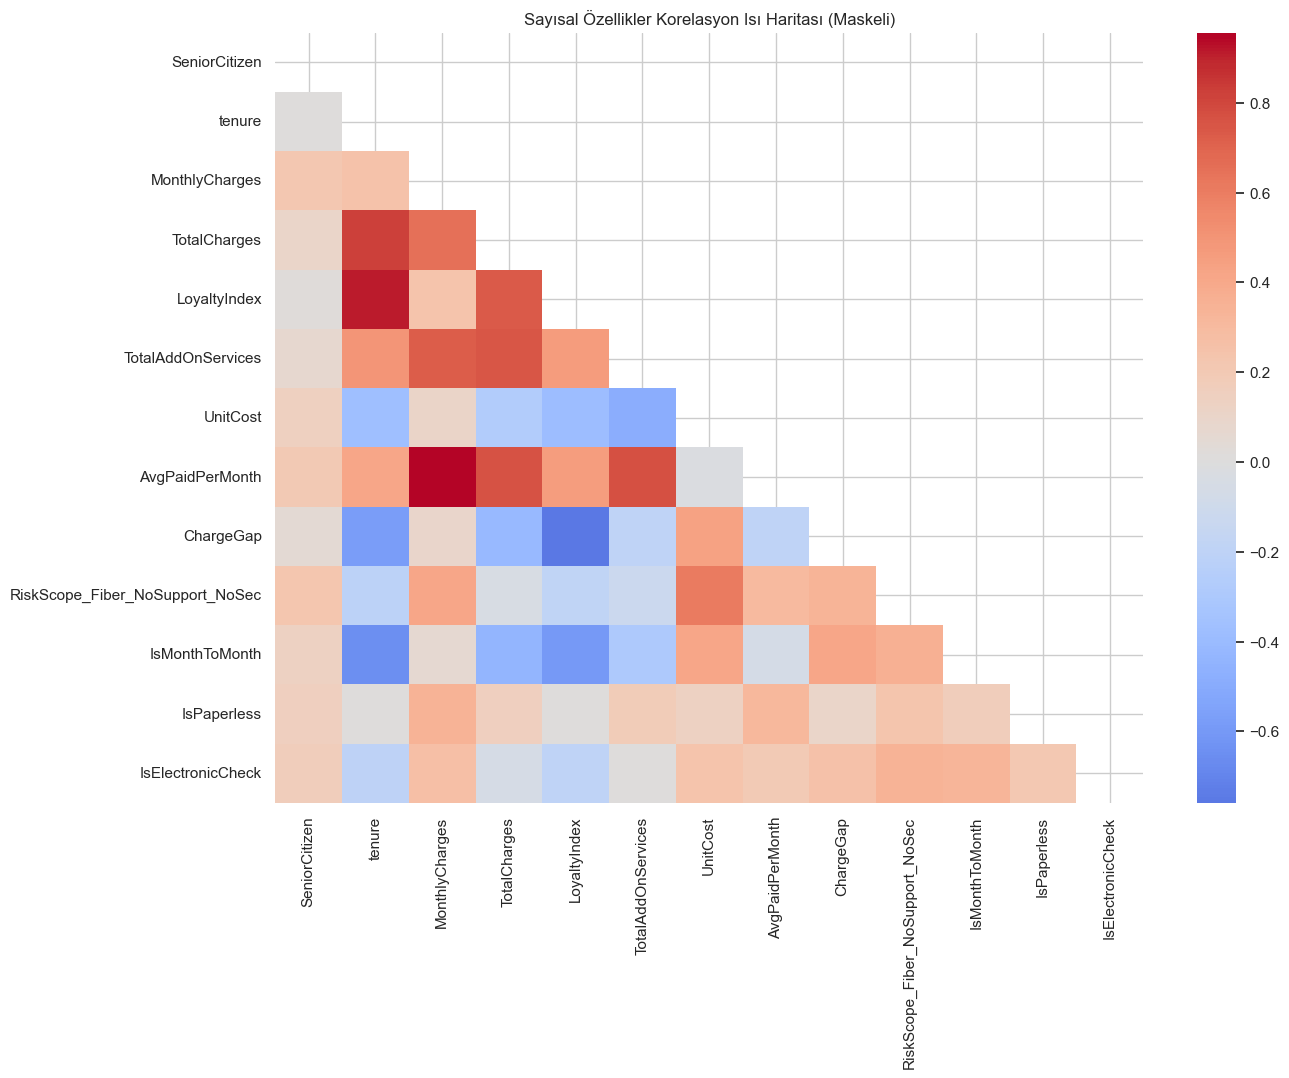

In [11]:
# =========================
# 9) EDA - Correlation Heatmap (masked)
# =========================

num_df = df_feat[numeric_cols].copy()

# NaN doldur (EDA için)
for c in num_df.columns:
    num_df[c] = pd.to_numeric(num_df[c], errors="coerce")
    num_df[c] = num_df[c].fillna(num_df[c].median())

corr = num_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 10))
sns.heatmap(corr, mask=mask, annot=False, cmap="coolwarm", center=0)
plt.title("Sayısal Özellikler Korelasyon Isı Haritası (Maskeli)")
plt.show()


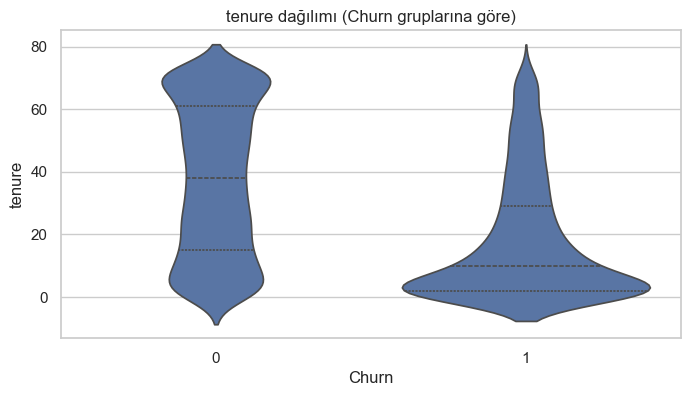

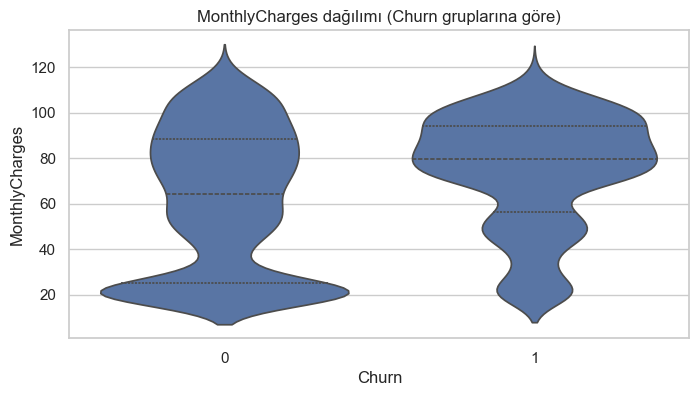

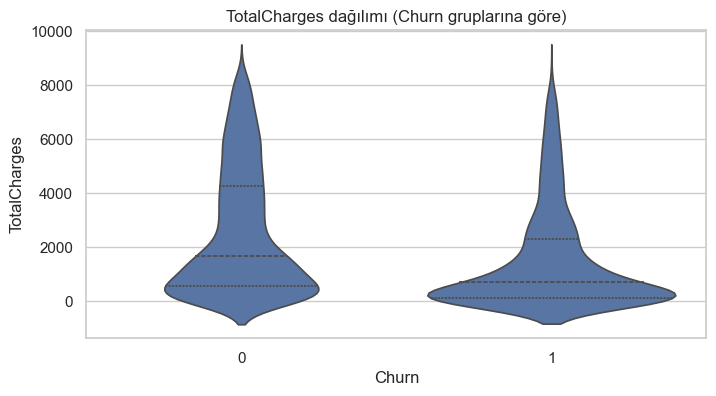

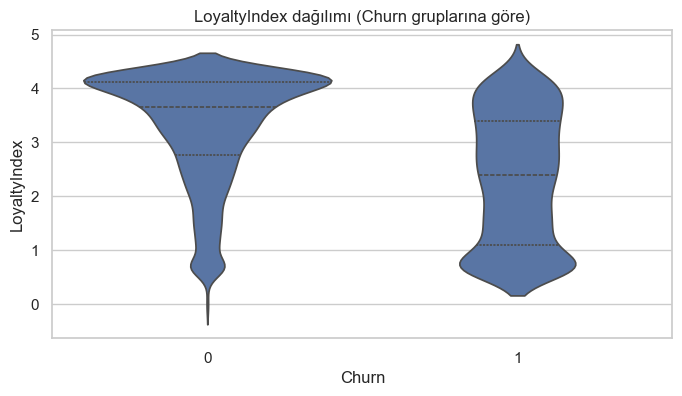

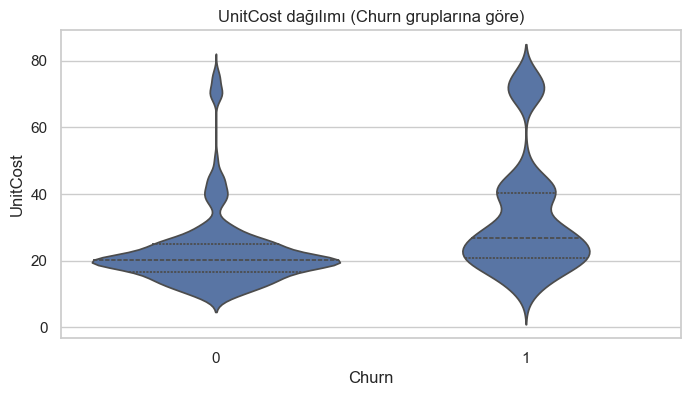

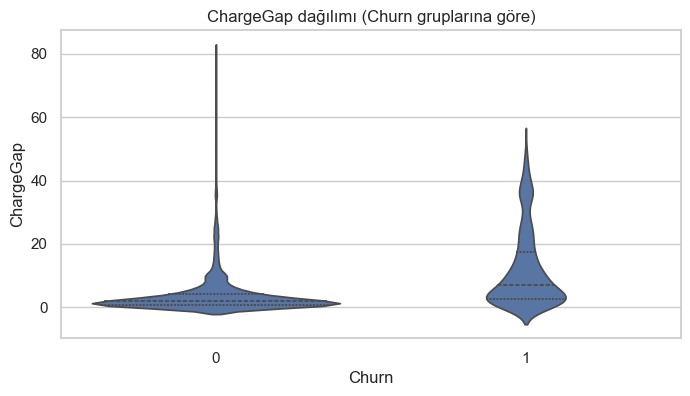

In [12]:
# =========================
# 9) EDA - Violin Plots
# =========================

# Önemli birkaç sayısalı seçelim (varsa)
candidate_nums = [c for c in ["tenure", "MonthlyCharges", "TotalCharges", "LoyaltyIndex", "UnitCost", "ChargeGap"] if c in df_feat.columns]

for col in candidate_nums:
    plt.figure(figsize=(8, 4))
    sns.violinplot(data=df_feat, x=cfg.target_col, y=col, inner="quartile")
    plt.title(f"{col} dağılımı (Churn gruplarına göre)")
    plt.show()


In [13]:
# =========================
# 9) EDA - Plotly Interactive Segmentation
# =========================

# Örnek interaktif: MonthlyCharges vs tenure (renk churn)
if all(c in df_feat.columns for c in ["MonthlyCharges", "tenure", cfg.target_col]):
    fig = px.scatter(
        df_feat,
        x="tenure",
        y="MonthlyCharges",
        color=cfg.target_col,
        hover_data=[c for c in ["Contract", "InternetService", "PaymentMethod", "TotalAddOnServices"] if c in df_feat.columns],
        title="Interaktif Segmentasyon: tenure vs MonthlyCharges (renk=Churn)"
    )
    fig.show()

# Örnek: Contract bazında churn oranı (bar)
if "Contract" in df_feat.columns:
    tmp = df_feat.groupby("Contract")[cfg.target_col].mean().reset_index().sort_values(cfg.target_col, ascending=False)
    fig2 = px.bar(tmp, x="Contract", y=cfg.target_col, title="Sözleşmeye göre Churn Oranı (ortalama)")
    fig2.show()


## 10) Boyut İndirgeme — PCA + Scree Plot (Kümülatif Varyans)

PCA uygularken:
- **Kategorikler** one-hot ile açılmalı,
- **Sayısallar** standardize edilmeli,
- Sonra PCA ile bileşen varyansları incelenmeli.

Bu adımda:
1. Tüm feature seti → `ColumnTransformer` ile numeric matrise çevrilir
2. PCA fit edilir → ilk N bileşenin varyans açıklama oranı hesaplanır
3. **Scree Plot** ile 90% ve 95% eşikleri görselleştirilir

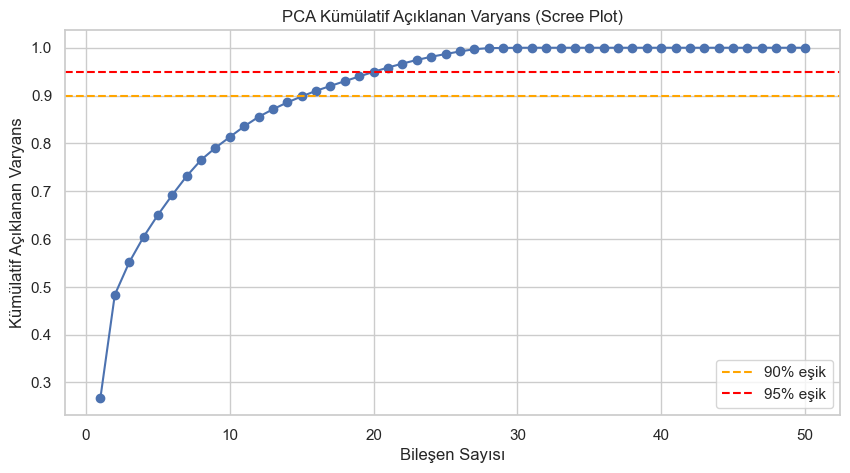

90% varyans için gereken bileşen: 16
95% varyans için gereken bileşen: 21


In [14]:
# =========================
# 10) PCA
# =========================

def build_preprocess_for_pca(df: pd.DataFrame, cfg: TelcoConfig) -> Tuple[ColumnTransformer, List[str], List[str]]:
    """
    PCA için: tüm feature setini numeric matrise çevirmek gerekir.
    - numeric: median impute + scaler
    - categorical: most_frequent impute + onehot
    """
    X = df.drop(columns=[cfg.target_col]) if cfg.target_col in df.columns else df.copy()
    
    num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    cat_cols = [c for c in X.columns if c not in num_cols]
    
    if cfg.id_col in cat_cols:
        cat_cols.remove(cfg.id_col)
    if cfg.id_col in num_cols:
        num_cols.remove(cfg.id_col)
    
    numeric_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    
    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    
    pre = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, num_cols),
            ("cat", categorical_pipe, cat_cols)
        ],
        remainder="drop"
    )
    return pre, num_cols, cat_cols

pre_pca, pca_num_cols, pca_cat_cols = build_preprocess_for_pca(df_feat, cfg)

X = df_feat.drop(columns=[cfg.target_col])
y = df_feat[cfg.target_col].values

# Preprocess -> matrix
X_mat = pre_pca.fit_transform(X)

# PCA
pca = PCA(n_components=min(50, X_mat.shape[1]))  # ilk 50 bileşen (ya da feature sayısı)
X_pca = pca.fit_transform(X_mat)

expl = pca.explained_variance_ratio_
cum_expl = np.cumsum(expl)

# Scree plot (kümülatif varyans)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cum_expl)+1), cum_expl, marker="o")
plt.axhline(0.90, linestyle="--", color="orange", label="90% eşik")
plt.axhline(0.95, linestyle="--", color="red", label="95% eşik")
plt.title("PCA Kümülatif Açıklanan Varyans (Scree Plot)")
plt.xlabel("Bileşen Sayısı")
plt.ylabel("Kümülatif Açıklanan Varyans")
plt.legend()
plt.grid(True)
plt.show()

# 90% ve 95% için gereken bileşen sayıları
k90 = int(np.argmax(cum_expl >= 0.90) + 1) if np.any(cum_expl >= 0.90) else len(cum_expl)
k95 = int(np.argmax(cum_expl >= 0.95) + 1) if np.any(cum_expl >= 0.95) else len(cum_expl)

print(f"90% varyans için gereken bileşen: {k90}")
print(f"95% varyans için gereken bileşen: {k95}")

## 11) Final Data Export — "Model eğitimine hazır matris" kaydı

Bu bölüm, model eğitim pipeline'ına girecek **"hazır"** matrisi export eder.

**Ne export ediyoruz?**
- `X_mat` — preprocess edilmiş, one-hot + scaled matris
- `y` — target vektörü
- `X_pca_95` — PCA ile 95% varyansı koruyan küçültülmüş matris
- **Metadata** — boyutlar, kolon sayıları, PCA k90/k95 bilgileri

> **Not:** Eğer production hedefin varsa en doğru yaklaşım: preprocess + model birlikte `joblib` ile kaydedilmesidir. Burada "model öncesi hazırlık artefact" olarak matrisi kaydediyoruz.

In [15]:
# =========================
# 11) Export Artifacts
# =========================

# PCA ile küçültülmüş matrisleri de export edelim
X_pca_95 = X_pca[:, :k95]

# Kaydetme: numpy .npz ile hem X hem y tek dosyada
npz_path = os.path.join(ARTIFACT_DIR, "telco_prepared_dataset.npz")
np.savez_compressed(npz_path, X=X_mat, y=y, X_pca_95=X_pca_95)

print(f"Saved: {npz_path}")
print(f"  X_mat shape     : {X_mat.shape}")
print(f"  y shape         : {y.shape}")
print(f"  X_pca_95 shape  : {X_pca_95.shape}")

# Ayrıca metadata: boyutlar, kolon sayıları, PCA k95 vb.
meta = {
    "n_rows": int(df_feat.shape[0]),
    "n_features_after_preprocess": int(X_mat.shape[1]),
    "pca_k90": int(k90),
    "pca_k95": int(k95),
    "target_col": cfg.target_col,
    "random_state": RANDOM_STATE
}
meta_path = os.path.join(ARTIFACT_DIR, "export_metadata.json")
DataIO.save_json(meta, meta_path)
print(f"Saved: {meta_path}")

Saved: artifacts\telco_prepared_dataset.npz
  X_mat shape     : (7043, 59)
  y shape         : (7043,)
  X_pca_95 shape  : (7043, 21)
Saved: artifacts\export_metadata.json


## 12) Rapor Özeti

Bu notebook'u "tam DS standardı" yapmak için rapor özeti:

- **Audit:** En problemli kolonlar ve aksiyon
- **Temizlik:** `TotalCharges` dönüşümü ve imputing mantığı
- **Feature Engineering:** Hangi yeni özellikler churn ile anlamlı çıktı?
- **İstatistiksel testler:** En düşük p-value'lar
- **VIF:** En yüksek VIF'li değişkenler
- **PCA:** 90%/95% varyans için gereken bileşen sayısı
- **Export:** artifacts dosyaları

In [16]:
# =========================
# 12) Summary Report
# =========================

summary = {}

# Churn oranı
if cfg.target_col in df_feat.columns:
    summary["churn_rate"] = round(float(df_feat[cfg.target_col].mean()), 4)

# Audit'ten en düşük fill_rate
summary["lowest_fill_rate_columns"] = audit_df.head(10)[["column", "fill_rate", "null_count"]].to_dict("records")

# İstatistik testlerinden en anlamlılar
summary["top_chi_square"] = chi_df.head(10).to_dict("records") if len(chi_df) else []
summary["top_welch_ttest"] = t_df.head(10).to_dict("records") if len(t_df) else []

# VIF en yüksekler
summary["top_vif"] = vif_df.head(10).to_dict("records") if len(vif_df) else []

# PCA
summary["pca_k90"] = int(k90)
summary["pca_k95"] = int(k95)

# Export
summary["artifacts"] = [
    "data_health_audit.parquet",
    "chi_square_results.parquet",
    "welch_ttest_results.parquet",
    "vif.parquet",
    "telco_prepared_dataset.npz",
    "export_metadata.json",
    "notebook_summary.json"
]

summary_path = os.path.join(ARTIFACT_DIR, "notebook_summary.json")
DataIO.save_json(summary, summary_path)
print(f"Saved: {summary_path}")

# Özet göster
print("\n" + "="*50)
print("📊 NOTEBOOK SUMMARY")
print("="*50)
print(f"  Churn Rate         : {summary.get('churn_rate', 'N/A')}")
print(f"  PCA k90            : {summary.get('pca_k90', 'N/A')} bileşen")
print(f"  PCA k95            : {summary.get('pca_k95', 'N/A')} bileşen")
print(f"  Chi-Square top feat: {chi_df.iloc[0]['feature'] if len(chi_df) else 'N/A'}")
print(f"  Welch top feat     : {t_df.iloc[0]['feature'] if len(t_df) else 'N/A'}")
print(f"  Highest VIF        : {vif_df.iloc[0]['feature'] if len(vif_df) else 'N/A'} ({vif_df.iloc[0]['vif']:.2f})" if len(vif_df) else "")
print("="*50)

summary

Saved: artifacts\notebook_summary.json

📊 NOTEBOOK SUMMARY
  Churn Rate         : 0.2654
  PCA k90            : 16 bileşen
  PCA k95            : 21 bileşen
  Chi-Square top feat: Contract
  Welch top feat     : IsMonthToMonth
  Highest VIF        : AvgPaidPerMonth (1312.65)


{'churn_rate': 0.2654,
 'lowest_fill_rate_columns': [{'column': 'customerID',
   'fill_rate': 1.0,
   'null_count': 0},
  {'column': 'MonthlyCharges', 'fill_rate': 1.0, 'null_count': 0},
  {'column': 'PaymentMethod', 'fill_rate': 1.0, 'null_count': 0},
  {'column': 'PaperlessBilling', 'fill_rate': 1.0, 'null_count': 0},
  {'column': 'Contract', 'fill_rate': 1.0, 'null_count': 0},
  {'column': 'StreamingMovies', 'fill_rate': 1.0, 'null_count': 0},
  {'column': 'StreamingTV', 'fill_rate': 1.0, 'null_count': 0},
  {'column': 'TechSupport', 'fill_rate': 1.0, 'null_count': 0},
  {'column': 'DeviceProtection', 'fill_rate': 1.0, 'null_count': 0},
  {'column': 'TotalCharges', 'fill_rate': 1.0, 'null_count': 0}],
 'top_chi_square': [{'feature': 'Contract',
   'test': 'chi_square',
   'chi2': 1184.5965720837926,
   'dof': 2,
   'p_value': 5.863038300673391e-258,
   'n_unique': 3},
  {'feature': 'TenureBucket',
   'test': 'chi_square',
   'chi2': 927.329274556515,
   'dof': 4,
   'p_value': 1.995

---

## ✅ Sonuç

Bu notebook **uçtan uca DS pipeline**'ını kapsar:

```
Audit → Temizlik → Feature Engineering → İstatistiksel Test → VIF → EDA → PCA → Export
```

Tüm artefactlar `artifacts/` klasörüne kaydedilmiştir ve **model eğitim pipeline**'ına girmeye hazırdır.

| Artifact | Format | Açıklama |
|----------|--------|----------|
| `data_health_audit.parquet` | Parquet | Veri sağlık raporu |
| `chi_square_results.parquet` | Parquet | Kategorik test sonuçları |
| `welch_ttest_results.parquet` | Parquet | Sayısal test sonuçları |
| `vif.parquet` | Parquet | Multicollinearity raporu |
| `telco_prepared_dataset.npz` | NumPy | X_mat, y, X_pca_95 matrisleri |
| `export_metadata.json` | JSON | Boyut ve PCA metadata |
| `notebook_summary.json` | JSON | Notebook özet raporu |